# Speed testing for mode manipulators (TidalPy.tides)


In [1]:
from time import time as timer
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

In [2]:
from TidalPy import version
from TidalPy.tides.mode_manipulation import find_mode_manipulators

In [8]:
@njit()
def cpl_neg_imk_helper_func(tidal_frequencies, fixed_k2: float, fixed_q: float):
    """ Njit-safe helper function for calculating -Imk2 for CPL method.

    Parameters
    ----------
    tidal_frequencies : Dict[FreqSig, FloatArray]
        Njit-safe TypedDict of tidal frequencies.
    fixed_k2 : float
        World's static k2
    fixed_q : float
        Fixed dissipation Q factor.

    Returns
    -------
    neg_imk_by_unique_freq : Dict[FreqSig, ComplexArray]
    """

    # Build fake values so that njit can compile the function
    fake_index = list(tidal_frequencies.keys())[0]
    fake_freq = tidal_frequencies[fake_index]
    neg_imk_by_unique_freq = {(-100, -100): fake_freq * (1. + 1.j)}

    # Real calculation
    for freq_sig, freq in tidal_frequencies.items():
        # The 0 * fake_freq is to ensure the correct array size is used.
        neg_imk_by_unique_freq[freq_sig] = fixed_k2 * (1. - (1.j / fixed_q)) + (0. * fake_freq)

    # Delete fake frequency used to compile function
    del neg_imk_by_unique_freq[(-100, -100)]

    return neg_imk_by_unique_freq

In [4]:
N_range = np.logspace(0, 6, 20, dtype=np.int32)
order_ls = {'-': 2, '--': 3, '-.': 4}
eccen_truncs = {'b': 2, 'g': 6, 'orange': 10, 'r': 20}

radius = 1.e6
gravity = 9.3
density = 1000.
shear_modulus = 50.e9
tidal_scale = 1.
tidal_susceptibility = 1.e22
tidal_host_mass = 1.e27
constant_cmplex_compliance = shear_modulus**(-1) + 1.0j * (shear_modulus*0.1)**(-1)
orbital_freq = 2. * np.pi / (86400. * 6)
spin_freq = 1.1 * orbital_freq

In [9]:
eccen_run_times = dict()
inclin_run_times = dict()
calculate_run_times = dict()
collapse_run_times = dict()

eccen_compile_times = list()
inclin_compile_times = list()
calculate_compile_times = list()
collapse_compile_times = list()
cases = list()

for ls, order_l in order_ls.items():
    for color, eccen_trunc in eccen_truncs.items():

        cases.append((order_l, eccen_trunc))

        calculate_terms, collapse_modes, eccentricity_func, inclination_func = \
            find_mode_manipulators(order_l, eccen_trunc, True)

        # Compile Time Calculations
        x = np.linspace(0.1, 0.9, 5)
        spin_freq_x = spin_freq * np.ones_like(x)
        orb_freq_x = orbital_freq * np.ones_like(x)
        semi_a_x = orb_freq_x**(-1)
        tidal_susceptibility_x = tidal_susceptibility * np.ones_like(semi_a_x)

        eccen_compile_t0 = timer()
        eccen_res = eccentricity_func(x)
        eccen_compile_time = timer() - eccen_compile_t0
        eccen_compile_times.append(eccen_compile_time)

        inclin_compile_t0 = timer()
        obliquity_res = inclination_func(x)
        inclin_compile_time = timer() - inclin_compile_t0
        inclin_compile_times.append(inclin_compile_time)

        calculate_terms_t0 = timer()
        freqs, results = calculate_terms(spin_freq_x, orb_freq_x, semi_a_x, radius, eccen_res, obliquity_res)
        calculate_compile_time = timer() - calculate_terms_t0
        calculate_compile_times.append(calculate_compile_time)
        
        complex_comp = cpl_neg_imk_helper_func(freqs, fixed_k2=.3, fixed_q=100.)

        collapse_modes_t0 = timer()
        output = \
            collapse_modes(gravity, radius, density, shear_modulus, tidal_scale, tidal_host_mass,
                           tidal_susceptibility_x, complex_comp, results, order_l, cpl_ctl_method=False)
        collapse_compile_time = timer() - collapse_modes_t0
        collapse_compile_times.append(collapse_compile_time)

        # Run Time Calculations
        eccen_run_time_avg_at_case = list()
        inclin_run_time_avg_at_case = list()
        calculate_time_avg_at_case = list()
        collapse_time_avg_at_case = list()
        eccen_run_time_std_at_case = list()
        inclin_run_time_std_at_case = list()
        calculate_time_std_at_case = list()
        collapse_time_std_at_case = list()
        for N in N_range:
            x = np.linspace(0.1, 0.9, N)
            spin_freq_x = spin_freq * np.ones_like(x)
            orb_freq_x = orbital_freq * np.ones_like(x)
            semi_a_x = orb_freq_x**(-1)
            tidal_susceptibility_x = tidal_susceptibility * np.ones_like(semi_a_x)

            eccen_res = eccentricity_func(x)
            obliquity_res = inclination_func(x)
            freqs, results = calculate_terms(spin_freq_x, orb_freq_x, semi_a_x, radius, eccen_res, obliquity_res)
            complex_comp = cpl_neg_imk_helper_func(freqs, fixed_k2=.3, fixed_q=100.)
            
            output = \
                collapse_modes(gravity, radius, density, shear_modulus, tidal_scale, tidal_host_mass,
                               tidal_susceptibility_x, complex_comp, results, order_l, cpl_ctl_method=True)

            eccen_timing = %timeit -o eccentricity_func(x)
            inclin_timing = %timeit -o inclination_func(x)
            calculate_timing = %timeit -o calculate_terms(spin_freq_x, orb_freq_x, semi_a_x, radius,\
                eccen_res, obliquity_res)
            collapse_timing = %timeit -o collapse_modes(gravity, radius, density, shear_modulus, tidal_scale,\
                tidal_host_mass, tidal_susceptibility_x, complex_comp, results, order_l, cpl_ctl_method=False)

            eccen_run_time_avg_at_case.append(eccen_timing.average)
            inclin_run_time_avg_at_case.append(inclin_timing.average)
            calculate_time_avg_at_case.append(calculate_timing.average)
            collapse_time_avg_at_case.append(collapse_timing.average)
            eccen_run_time_std_at_case.append(eccen_timing.stdev)
            inclin_run_time_std_at_case.append(inclin_timing.stdev)
            calculate_time_std_at_case.append(calculate_timing.stdev)
            collapse_time_std_at_case.append(collapse_timing.stdev)

        key = (ls, order_l, color, eccen_trunc)
        eccen_run_times[key] = (np.asarray(eccen_run_time_avg_at_case), np.asarray(eccen_run_time_std_at_case))
        inclin_run_times[key] = (np.asarray(inclin_run_time_avg_at_case), np.asarray(inclin_run_time_std_at_case))
        calculate_run_times[key] = (np.asarray(calculate_time_avg_at_case), np.asarray(calculate_time_std_at_case))
        collapse_run_times[key] = (np.asarray(collapse_time_avg_at_case), np.asarray(collapse_time_std_at_case))

64.4 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
61.3 µs ± 553 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
168 µs ± 681 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
180 µs ± 247 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
64.6 µs ± 386 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
61.3 µs ± 392 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
166 µs ± 768 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
180 µs ± 317 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
64.5 µs ± 331 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
60.4 µs ± 96.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
168 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
180 µs ± 697 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
64.5 µs ± 89.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
61.4 µs ± 397 ns per loop (mean ± std. dev. of 7 runs,

633 µs ± 8.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.7 ms ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
76 µs ± 171 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
141 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
804 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.83 ms ± 55.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
78.6 µs ± 449 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
165 µs ± 699 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.06 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.65 ms ± 62.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
82.3 µs ± 82.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
196 µs ± 435 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.21 ms ± 57.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.68 ms ± 46.2 µs per loop (mean ± std. dev. of 7 runs, 100 

241 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
219 µs ± 2.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
69.7 µs ± 818 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
62.8 µs ± 715 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
257 µs ± 1.98 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
222 µs ± 860 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
69 µs ± 837 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
61.3 µs ± 55.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
249 µs ± 3.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
223 µs ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
69.1 µs ± 666 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
62.2 µs ± 813 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
254 µs ± 322 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
232 µs ± 4.46 µs per loop (mean ± std. dev. of 7 runs, 1000 lo

223 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
641 µs ± 8.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
16.3 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
31.1 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
301 µs ± 6.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
848 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
21.7 ms ± 890 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.3 ms ± 985 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
364 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.07 ms ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
28.6 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.6 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
557 µs ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.43 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each

75.9 µs ± 797 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
64.4 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
361 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
323 µs ± 3.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
74.9 µs ± 493 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
64.1 µs ± 581 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
361 µs ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
347 µs ± 2.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
75.4 µs ± 615 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
66.3 µs ± 404 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
374 µs ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
376 µs ± 1.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
74.2 µs ± 176 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
65.3 µs ± 727 ns per loop (mean ± std. dev. of 7 runs, 1

491 ms ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
18.2 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.5 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
835 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
661 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.4 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.7 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.15 s ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
891 ms ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31.3 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.7 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.53 s ± 45.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.17 s ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
41.5 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
31.3 ms ± 675 µs per loop (m

1.01 ms ± 963 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.27 ms ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
124 µs ± 208 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
75.2 µs ± 631 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.21 ms ± 2.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.62 ms ± 4.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
138 µs ± 470 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
80 µs ± 193 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.44 ms ± 3.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.15 ms ± 5.67 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
154 µs ± 499 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
86.8 µs ± 234 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.81 ms ± 2.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.86 ms ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 10

239 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
250 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
68.9 µs ± 166 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
65.2 µs ± 393 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
243 µs ± 5.71 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
252 µs ± 3.98 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
70.2 µs ± 182 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
65.4 µs ± 347 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
240 µs ± 768 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
256 µs ± 2.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
68.9 µs ± 149 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
65.7 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
253 µs ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
265 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 1000 

105 µs ± 187 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
306 µs ± 766 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.42 ms ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.05 ms ± 44.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
116 µs ± 215 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
380 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.44 ms ± 22.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.9 ms ± 57.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
128 µs ± 385 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
480 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.73 ms ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.8 ms ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
144 µs ± 200 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
607 µs ± 9.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops

79.1 µs ± 109 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
68.5 µs ± 520 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
460 µs ± 788 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
352 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
79 µs ± 64.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
68 µs ± 95.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
478 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
371 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
78.1 µs ± 227 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
67.3 µs ± 237 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
433 µs ± 1.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
367 µs ± 474 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
78.2 µs ± 72.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
67.8 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 10000

59.8 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
98.1 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.42 ms ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.52 ms ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
75.6 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
134 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.1 ms ± 29.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.61 ms ± 61.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
119 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
185 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.72 ms ± 46.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.65 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
157 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
302 ms ± 4.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.5 ms ±

775 µs ± 2.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
666 µs ± 937 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
89.8 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
72.4 µs ± 252 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
800 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
748 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
90.9 µs ± 155 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
74.1 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
858 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
870 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
91.7 µs ± 238 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
76.4 µs ± 121 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
947 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.03 ms ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 1000 l

41 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.97 s ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.11 s ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
69.2 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.7 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.05 s ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.8 s ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
93.7 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
73.7 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.45 s ± 35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.73 s ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
123 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
96.8 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.28 s ± 54.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.07 s ± 22.6 ms per loop (mean ±

231 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
106 µs ± 227 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
3.94 ms ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.51 ms ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
270 µs ± 431 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
120 µs ± 517 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.06 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.36 ms ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
321 µs ± 780 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
137 µs ± 443 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.5 ms ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.62 ms ± 28.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
403 µs ± 858 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
159 µs ± 307 ns per loop (mean ± std. dev. of 7 runs, 10000 loops eac

73.3 µs ± 171 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
367 µs ± 5.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
376 µs ± 829 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
76.4 µs ± 281 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
75 µs ± 326 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
391 µs ± 732 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
392 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
78.7 µs ± 134 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
75.4 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
403 µs ± 925 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
404 µs ± 1.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
77.4 µs ± 63 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
76 µs ± 95.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
411 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops

25.6 ms ± 445 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
215 µs ± 738 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
949 µs ± 2.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
14.4 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
34 ms ± 647 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
240 µs ± 458 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.21 ms ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
18 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.9 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
294 µs ± 799 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.63 ms ± 7.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
24.7 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
58.6 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
397 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.27 ms ± 

586 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
90.8 µs ± 273 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
77.6 µs ± 192 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
736 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
575 µs ± 2.83 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
91.3 µs ± 357 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
78.3 µs ± 177 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
767 µs ± 3.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
604 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
91.9 µs ± 668 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
79.6 µs ± 624 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
819 µs ± 1.98 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
666 µs ± 5.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
92.3 µs ± 607 ns per loop (mean ± std. dev. of 7 runs, 100

318 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
401 ms ± 29.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.94 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.4 ms ± 59.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
502 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
633 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.95 ms ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.7 ms ± 39.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
637 ms ± 44.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
843 ms ± 9.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.8 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
33 ms ± 886 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.59 s ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.22 s ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.8 ms ± 852 µs per loop (mea

1.6 ms ± 2.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.53 ms ± 2.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
115 µs ± 131 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
93.9 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.78 ms ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.84 ms ± 5.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
117 µs ± 84.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
99.9 µs ± 82.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.28 ms ± 6.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
120 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
109 µs ± 501 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.27 ms ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.92 ms ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 100 loop

11.1 s ± 50.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.07 s ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
224 ms ± 7.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
189 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.7 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.59 s ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
288 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
237 ms ± 4.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.1 s ± 65.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.5 s ± 67.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
137 µs ± 134 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
73.2 µs ± 243 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.7 ms ± 2.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
807 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
138 µs ± 170 ns per loop (mean

210 µs ± 716 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.2 ms ± 67.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.5 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
662 µs ± 6.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
251 µs ± 711 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
16.7 ms ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.9 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.12 ms ± 9.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
409 µs ± 3.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
41.7 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.7 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.27 ms ± 32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
478 µs ± 1.62 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
46.7 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4

### Plot Compile Times

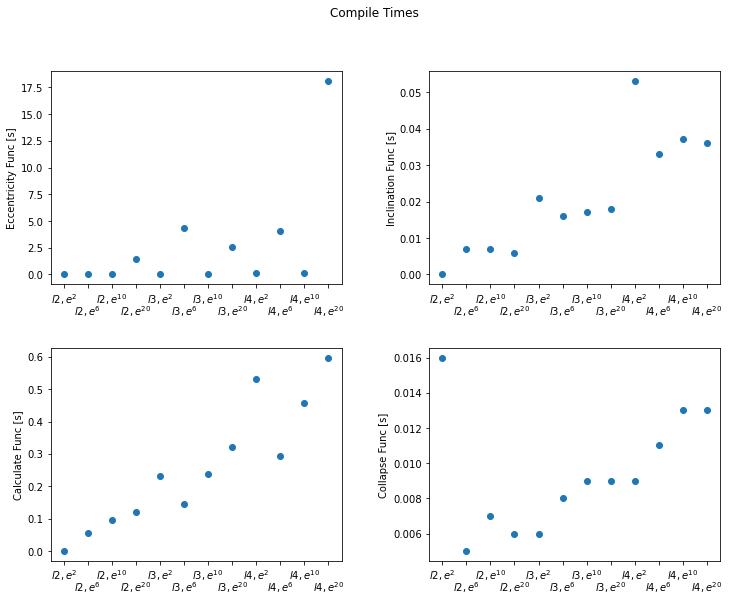

In [10]:
fig_compile, ax_compile = plt.subplots(2, 2, gridspec_kw={'wspace':0.3, 'hspace':0.3}, figsize=(12, 9))
fig_compile.suptitle('Compile Times')
ax_compile_eccen = ax_compile[0, 0]
ax_compile_inclin = ax_compile[0, 1]
ax_compile_calculate = ax_compile[1, 0]
ax_compile_collapse = ax_compile[1, 1]

ax_compile_eccen.set(ylabel='Eccentricity Func [s]')
ax_compile_inclin.set(ylabel='Inclination Func [s]')
ax_compile_calculate.set(ylabel='Calculate Func [s]')
ax_compile_collapse.set(ylabel='Collapse Func [s]')

x_names = ['$l' + f'{order_l}, ' + 'e^{' + f'{trunc}' + '}$' if i%2==0 else '\n$l' + f'{order_l}, ' + 'e^{' + f'{trunc}' + '}$' for i, (order_l, trunc) in enumerate(cases)]

ax_compile_eccen.scatter(range(len(x_names)), eccen_compile_times)
ax_compile_inclin.scatter(range(len(x_names)), inclin_compile_times)
ax_compile_calculate.scatter(range(len(x_names)), calculate_compile_times)
ax_compile_collapse.scatter(range(len(x_names)), collapse_compile_times)

for ax in [ax_compile_eccen, ax_compile_inclin, ax_compile_calculate, ax_compile_collapse]:

    ax.set_xticks(range(len(x_names)))
    ax.set_xticklabels(x_names)

plt.show()
fig_compile.savefig(f'CompileTimePlot_{version}.pdf')

### Plot Run Times

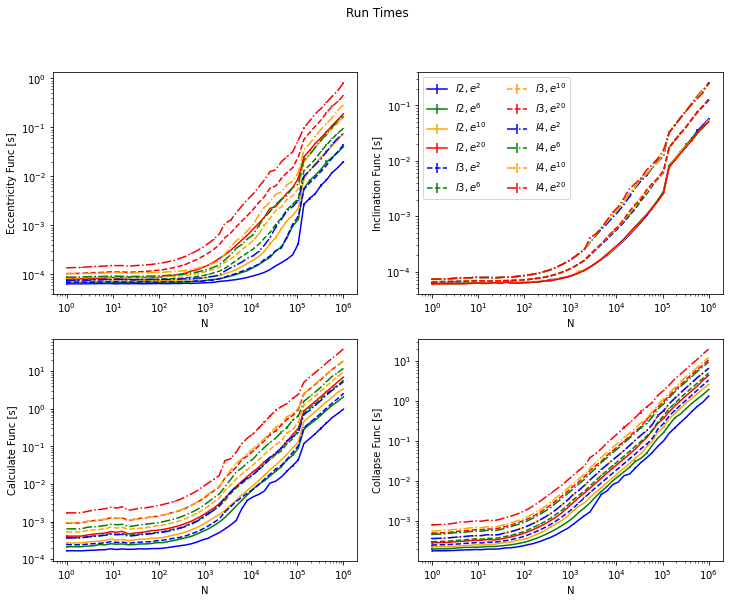

In [11]:
fig_runtime, ax_runtime = plt.subplots(2, 2, gridspec_kw={'wspace':0.2, 'hspace':0.2}, figsize=(12, 9))
fig_runtime.suptitle('Run Times')
ax_runtime_eccen = ax_runtime[0, 0]
ax_runtime_inclin = ax_runtime[0, 1]
ax_runtime_calculate = ax_runtime[1, 0]
ax_runtime_collapse = ax_runtime[1, 1]

ax_runtime_eccen.set(ylabel='Eccentricity Func [s]')
ax_runtime_inclin.set(ylabel='Inclination Func [s]')
ax_runtime_calculate.set(ylabel='Calculate Func [s]')
ax_runtime_collapse.set(ylabel='Collapse Func [s]')

for ax in [ax_runtime_eccen, ax_runtime_inclin, ax_runtime_calculate, ax_runtime_collapse]:
    ax.set(xlabel='N', xscale='log', yscale='log')

for key, (eccen_avg, eccen_std) in eccen_run_times.items():
    inclin_avg, inclin_std = inclin_run_times[key]
    calculate_avg, calculate_std = calculate_run_times[key]
    collapse_avg, collapse_std = collapse_run_times[key]
    ls, order_l, color, eccen_trunc = key

    if color == 'o':
        color = 'orange'

    label = '$l' + f'{order_l}, ' + 'e^{' + f'{eccen_trunc}' + '}$'
    ax_runtime_eccen.errorbar(N_range, eccen_avg, yerr=eccen_std, c=color, ls=ls, label=label)
    ax_runtime_inclin.errorbar(N_range, inclin_avg, yerr=inclin_std, c=color, ls=ls, label=label)
    ax_runtime_calculate.errorbar(N_range, calculate_avg, yerr=calculate_std, c=color, ls=ls, label=label)
    ax_runtime_collapse.errorbar(N_range, collapse_avg, yerr=collapse_std, c=color, ls=ls, label=label)

ax_runtime_inclin.legend(loc='best', ncol=2)
plt.show()
fig_runtime.savefig(f'RunTimePlot_{version}.pdf')